# ResNet 직접 구현하기
---
**"ResNet을 직접 구현하고 Plain Network와 비교하여 그 성능을 확인하는 프로젝트"**
<br>
#### 😏 목차
1. ResNet 구현
2. Plain Network 구현
3. 성능 비교
4. 회고

#### 모듈

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

---
## 1. ResNet 구현
- ResNet-34: Block은 3x3 kernel인 Convolution layer로만 구성
- ResNet-50: 1x1 Convolution이 앞뒤로 붙어있음

### 1-1 ResNet 블록 구성

#### conv 블럭

In [2]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

#### ResNet 블럭

In [3]:
def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                   is_50=True):
    # 입력 레이어
    x = input_layer

    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0: 
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)

    return x

#### ResNet 모델

In [4]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 1-2 ResNet-34

In [5]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

### 1-3 ResNet-50

In [6]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True, name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

---
## 2. Plain Network 구현

### 2-1 Plain Network 블록 구성

In [7]:
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [8]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape) # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 2-2 Plain Network-34

In [9]:
plainnet_34 = build_plainnet(input_shape=(32,32,3), is_50=False, name='Plain_34')
plainnet_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 8, 8, 64)          256

### 2-3 Plain Network-50

In [10]:
plainnet_50 = build_plainnet(input_shape=(32,32,3), is_50=True, name='Plain_50')
plainnet_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_115 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 8, 8, 64)          256

---
## 3. 성능 비교

### 3-1 데이터 준비
- tensorflow-datasets의 cats_vs_dogs 데이터

In [11]:
import urllib3
urllib3.disable_warnings()

tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True # as_supervised False인 경우 라벨 인수가 누락되었다는 TypeError:발생
)

In [12]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
ds_info.features["label"].num_classes

2

In [15]:
ds_info.features["label"].names

['cat', 'dog']

#### 정규화

In [16]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])# 이미지 리사이징
    return tf.cast(image, tf.float32) / 255., label

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 샘플 확인

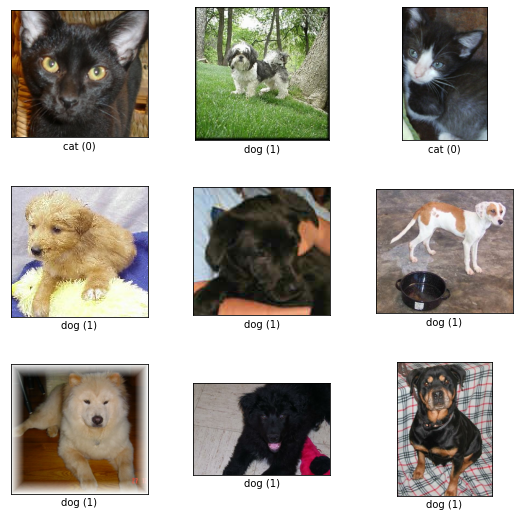

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

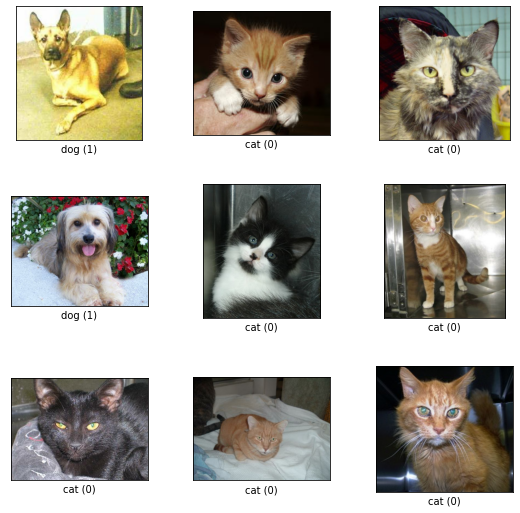

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

### 3-2 ResNet-34 vs Plain Network-34 비교

In [20]:
BATCH_SIZE = 16
EPOCH = 10

In [21]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### ResNet-34

In [22]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

In [23]:
model_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
1163/1163 [==============================] - 324s 255ms/step - loss: 2.3342 - accuracy: 0.5774 - val_loss: 3.5016 - val_accuracy: 0.5052
Epoch 2/10
1163/1163 [==============================] - 306s 263ms/step - loss: 1.2389 - accuracy: 0.6743 - val_loss: 0.9376 - val_accuracy: 0.6777
Epoch 3/10
1163/1163 [==============================] - 291s 251ms/step - loss: 0.8170 - accuracy: 0.7344 - val_loss: 1.0165 - val_accuracy: 0.5695
Epoch 4/10
1163/1163 [==============================] - 293s 252ms/step - loss: 0.6838 - accuracy: 0.7482 - val_loss: 0.7623 - val_accuracy: 0.7116
Epoch 5/10
1163/1163 [==============================] - 292s 251ms/step - loss: 0.6203 - accuracy: 0.7808 - val_loss: 0.6473 - val_accuracy: 0.7440
Epoch 6/10
1163/1163 [==============================] - 292s 251ms/step - loss: 0.5531 - accuracy: 0.8096 - val_loss: 0.9507 - val_accuracy: 0.5923
Epoch 7/10
1163/1163 [==============================] - 292s 251ms/step - loss: 0.5363 - accuracy: 0.8243 - val_

#### Plain Network-34

In [31]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [32]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 284s 237ms/step - loss: 1.9515 - accuracy: 0.5094 - val_loss: 1.5741 - val_accuracy: 0.4400
Epoch 2/10
1163/1163 [==============================] - 279s 240ms/step - loss: 1.1352 - accuracy: 0.5259 - val_loss: 1.5228 - val_accuracy: 0.4603
Epoch 3/10
1163/1163 [==============================] - 279s 240ms/step - loss: 0.9509 - accuracy: 0.5196 - val_loss: 0.8519 - val_accuracy: 0.5310
Epoch 4/10
1163/1163 [==============================] - 279s 240ms/step - loss: 0.8664 - accuracy: 0.5187 - val_loss: 0.8372 - val_accuracy: 0.5071
Epoch 5/10
1163/1163 [==============================] - 279s 240ms/step - loss: 0.8210 - accuracy: 0.5072 - val_loss: 0.7824 - val_accuracy: 0.4830
Epoch 6/10
1163/1163 [==============================] - 280s 241ms/step - loss: 0.7882 - accuracy: 0.5049 - val_loss: 0.7853 - val_accuracy: 0.4858
Epoch 7/10
1163/1163 [==============================] - 280s 241ms/step - loss: 0.7735 - accuracy: 0.5251 - val_

#### 시각화

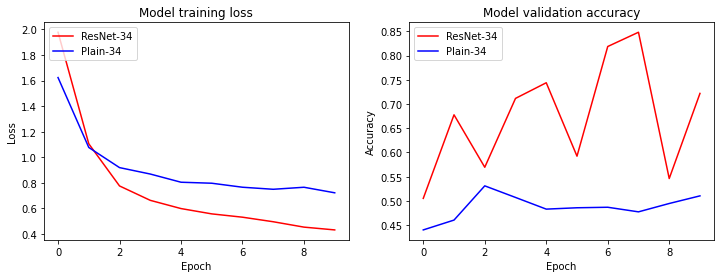

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.show()

---
## 4. 회고

- 그래프를 보면 ResNet이 Plain Network에 비해 성능이 좋음을 확인할 수 있다.
- ResNet의 accuracy가 불안정함을 확인할 수 있다.